<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [1]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy

from bs4 import BeautifulSoup

## 1) *Clean:* Job Listings from indeed.com that contain the title "Data Scientist" 

You have `job_listings.csv` in the data folder for this module. The text data in the description column is still messy - full of html tags. Use the [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library to clean up this column. You will need to read through the documentation to accomplish this task. 

In [2]:
from bs4 import BeautifulSoup
import requests

df = pd.read_csv('./data/job_listings.csv')

In [3]:
df.head()

,Unnamed: 0,description,title
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist


In [4]:
x = df['description'][0]

df['description_clean'] = df['description'].apply(lambda x: BeautifulSoup(x).get_text())

In [5]:
df.head()

,Unnamed: 0,description,title,description_clean
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist,"b""Job Requirements:\nConceptual understanding ..."
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I,"b'Job Description\n\nAs a Data Scientist 1, yo..."
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level,b'As a Data Scientist you will be working on c...
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist,"b'$4,969 - $6,756 a monthContractUnder the gen..."
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist,b'Location: USA \xe2\x80\x93 multiple location...


## 2) Use Spacy to tokenize the listings 

In [6]:
from spacy.tokenizer import Tokenizer
nlp = spacy.load("en_core_web_lg")
tokenizer = Tokenizer(nlp.vocab)

In [7]:
tokens = []

for doc in tokenizer.pipe(df['description_clean']):
    doc_tokens = []
    
    for token in doc:
        if (token.is_stop == False) & (token.is_punct == False):
            doc_tokens.append(token.text.lower())
      
    tokens.append(doc_tokens)

In [8]:
tokens[0]

['b"job',
 'requirements:\\nconceptual',
 'understanding',
 'machine',
 'learning',
 'models',
 'like',
 'nai\\xc2\\xa8ve',
 'bayes,',
 'k-means,',
 'svm,',
 'apriori,',
 'linear/',
 'logistic',
 'regression,',
 'neural,',
 'random',
 'forests,',
 'decision',
 'trees,',
 'k-nn',
 'hands-on',
 'experience',
 '2',
 'them\\nintermediate',
 'expert',
 'level',
 'coding',
 'skills',
 'python/r.',
 '(ability',
 'write',
 'functions,',
 'clean',
 'efficient',
 'data',
 'manipulation',
 'mandatory',
 'role)\\nexposure',
 'packages',
 'like',
 'numpy,',
 'scipy,',
 'pandas,',
 'matplotlib',
 'etc',
 'python',
 'ggplot2,',
 'dplyr,',
 'tidyr',
 'r\\nability',
 'communicate',
 'model',
 'findings',
 'technical',
 'non-technical',
 'stake',
 'holders\\nhands',
 'experience',
 'sql/hive',
 'similar',
 'programming',
 'language\\nmust',
 'past',
 'work',
 'github,',
 'kaggle',
 'published',
 "article\\nmaster's",
 'degree',
 'statistics/mathematics/computer',
 'science',
 'quant',
 'specific',
 'fie

In [9]:
df['description_tokens'] = tokens

In [10]:
df.head()

,Unnamed: 0,description,title,description_clean,description_tokens
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist,"b""Job Requirements:\nConceptual understanding ...","[b""job, requirements:\nconceptual, understandi..."
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I,"b'Job Description\n\nAs a Data Scientist 1, yo...","[b'job, description\n\nas, data, scientist, 1,..."
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level,b'As a Data Scientist you will be working on c...,"[b'as, data, scientist, working, consulting, b..."
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist,"b'$4,969 - $6,756 a monthContractUnder the gen...","[b'$4,969, $6,756, monthcontractunder, general..."
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist,b'Location: USA \xe2\x80\x93 multiple location...,"[b'location:, usa, \xe2\x80\x93, multiple, loc..."


Still messy, but I'm going to leave it be for now.

## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [11]:
vect = CountVectorizer(stop_words='english')

vect.fit(df['description_clean'])

dtm = vect.transform(df['description_clean'])

In [12]:
print(vect.get_feature_names)

<bound method CountVectorizer.get_feature_names of CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)>


In [13]:
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())

In [14]:
dtm.head()

,00,000,02115,03,0356,04,062,06366,08,10,...,zenreach,zero,zeus,zf,zheng,zillow,zones,zoom,zuckerberg,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4) Visualize the most common word counts

In [32]:
dtm.sum().sort_values(ascending=False).head(22)

data           4394
xe2            1417
x80            1404
experience     1238
business       1198
work            976
team            972
science         956
learning        912
analytics       730
machine         686
analysis        675
skills          673
nexperience     616
models          614
product         578
statistical     566
x99s            564
solutions       530
new             527
scientist       511
insights        464
dtype: int64

In [78]:
wc_top20

,word_count
data,4394
xe2,1417
x80,1404
experience,1238
business,1198
work,976
team,972
science,956
learning,912
analytics,730


TypeError: unsupported operand type(s) for +: 'int' and 'str'

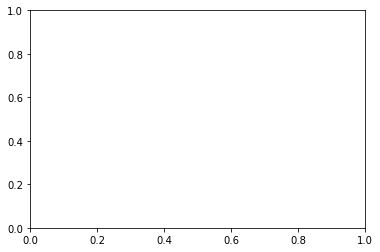

In [76]:
import squarify

squarify.plot(sizes=wc, label=wc.index, alpha=.8)

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [ ]:
##### Your Code Here #####
raise Exception("\nThis task is not complete. \nReplace this line with your code for the task."

## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [ ]:
##### Your Code Here #####
raise Exception("\nThis task is not complete. \nReplace this line with your code for the task."

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 